# Bias and Word Embeddings (Part 1)

This is the first Jupyter Notebook complementing my blog post: 

A very basic understanding of probability and linear algebra will be helpful, but no machine learning/natural language processing experience is needed to understand these notebooks. Please contact me if you think a certain concept needs to be clarified!

## What are word embeddings?

In order to understand word embeddings, a key paradigm in the natural language processing (NLP) community that we need to adopt is the idea of _text as data_. Once we treat a piece of text as data, we are able to use mathematical and statistical machine learning models to analyze this text.

Before word embeddings were developed, there were other methods used for representing a word as a _vector_ of real numbers, but the advantage of embeddings is that they are _distributed word representations_. This means that a machine learning model does not to use "one-hot encodings," where a word's vector is equal to the size of the entire vocabulary and every entry is equal to 0, except the one corresponding to the word, which is a 1. Instead, the model uses the _distributional hypothesis_, a term in linguistics that essentially states that a word's meaning is based on its context, so words that get mentioned in the same contexts usually have similar vectors. It can be argued that many of the recent advances in using computationally intensive neural networks for NLP tasks in the past 5-8 years, like machine translation and conversation agents, have happened due to the ability of word embeddings to capture a richer representation of textual data.

There are a couple algorithms to learn embeddings from a _training corpus_, and their authors have made the results of training their models on certain corpora open-source. The model we'll use here is _Globalized Vectors for Word Representation_ [(Pennington, Socher, and Manning, 2014)](https://nlp.stanford.edu/projects/glove/), or GloVe. Essentially, GloVe uses a co-occurrence matrix, where the rows and columns are represented by words, and the entries depend on how likely a word is to appear in the context of another word, in other words, through Bayes's rule. In addition to probabilistic methods, the values of the embeddings are "learned" through matrix factorization methods. The other major algorithm to generate word embeddings is known as _Word2Vec_ ([Mikolov et al, 2013](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)), in which the embeddings are learned through neural networks. 

I chose to use GloVe over Word2Vec for this investigation because it is much easier to interact with the data, available through text files rather than binary files, and implement my own functions to learn about the embeddings. These embeddings were trained on Wikipedia and newswire text, and can be downloaded [here](http://nlp.stanford.edu/data/glove.6B.zip).

## Interfacing with Pre-Trained Embeddings

Here, we read in the data, and create a list of words contained in the embeddings, a dictionary mapping words to vectors, and a matrix of all the vectors. 

In [130]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet as wn

In [6]:
f = open('glove.6B/glove.6B.100d.txt', 'r') 
vocab = []
embeddings = {}
matrix = []
for line in f:
    split_line = line.split()
    word = split_line[0]
    vector = np.asarray([float(i) for i in split_line[1:]])
    embeddings.update({word:vector})
    vocab.append(word)
    matrix.append(vector)

As expressed in the blog post, whether an analogy gets successfully encoded in an embedding is often used as a way to verify if the model is correct.  We use the definition from [Levy, Goldberg (2014)](http://www.aclweb.org/anthology/W14-1618) when evaluating analogies. The canonical example is $queen - king \approx woman - man$, where $queen$ is the unknown vector.

We solve the analogy as follows(where $v$ is a word in the vocabulary, $V$, and $cos$ represents cosine similarity, a term we'll discuss later on): $$argmax_{v \in V}(cos(v, woman - man + king)$$

In [23]:
def evaluate(word, relation, k = 4, return_list = False):
    """Takes in a target word, a list of two words expressing a relation,
    an integer denoting the amount of values that should be returned, and whether a list of words should be returned,
    or only the first item. k is set to 4 by default, in the case that the target word and the relation words
    answer the analogy.
    Returns a list of words of length [k - 3, k] that satisfy the analogy in order of decreasing cosine similarity"""
    if [i for i in [word, relation[0], relation[1]] if i not in embeddings]:
        raise ValueError("Word must be in vocabulary")
    result_vector = embeddings[relation[0]] - embeddings[relation[1]] + embeddings[word]
    nearest_indices = k_nearest_vectors(k, matrix, [result_vector])[0]
    closest_words = [vocab[i] for i in nearest_indices if vocab[i] != word and vocab[i] not in relation]
    if return_list:
        return closest_words
    else:
        return closest_words[0]

We define the following helper function to reduce the search space. 

In [25]:
def k_nearest_vectors(k, mtx, candidate_vector):
    """Takes in an integer value(k), a matrix (2D list) of all the vectors, and the vector (list) we want to compare.
    Returns an array of length k for indices of the most similar word vectors, and the cosine similarities of these vectors """
    cos_similarities = cosine_similarity(mtx, candidate_vector).flatten()
    k_sorted = np.flip(np.argsort(cos_similarities)[-k:], axis = 0)
    cos_sorted = np.flip(np.sort(cos_similarities), axis = 0)[:k]
    return k_sorted, cos_sorted

The following test tells us our helper function is correct: the item with the highest cosine similarity to a given word in the dataset will be the word itself. Because the function returns a list of indices, we check if the index corresponds most to the word we are checking by looking at its position in the vocabulary.

In [537]:
vocab.index('woman') == k_nearest_vectors(5, matrix, [embeddings['woman']])[0][0]

True

## Evaluation

Let's look at a couple analogies to make sure our evaluation function is working properly. We'll start with the example: "woman" is to "man" as "queen" is to "king."

In [278]:
evaluate('king', ['woman', 'man'])

'queen'

Embeddings can also reveal details like grammatical properties:

In [249]:
evaluate('hard', ['better', 'good']) #comparative adjectives

'harder'

In [250]:
evaluate('duck', ['men', 'man']) #singular/plural

'ducks'

In [251]:
evaluate('they', ['his', 'he']) #possessive forms

'their'

They can also help us answer questions about the world:

In [538]:
evaluate('china', ['moscow', 'russia']) #capitals of countries

'beijing'

In [305]:
evaluate('danzig', ['mumbai', 'bombay']) #former names of cities

'gdańsk'

In [314]:
evaluate('japan', ['europe', 'germany']) #country-continent mapping

'asia'

However, embeddings can also reveal problematic *biases* in language. 

In [129]:
evaluate('nurse', ['man', 'doctor']) #gender based on occupation

'woman'

In [383]:
evaluate('criminal', ['white', 'police']) #racial stereotypes

'black'

In [37]:
evaluate('terrorist', ['christianity', 'lawful']) #religious stereotypes

'islamic'

## Visualizing the Embeddings

Let's try to figure out why this is the case by looking at some of the mathematical properties of the embeddings.

But first, let's try to visualize our data. How exactly will this work, if each embedding is represented by a $[1 \times 100]$ vector? We turn to _principal component analysis_, a technique used for _dimensionality reduction_, in order to create a 2D representation of the data. 

Don't worry too much if this term is new! PCA basically compresses all the information captured in our dataset into vectors called principal components. Each principle component explains a certain percentage of the _variance_, or spread, of our data. We're going to specify that it needs 2 components, because we're going to make a plot on an x-y plane.

In [139]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 2)
mtx_2d = pca.fit_transform(matrix)
embeddings_2d = {vocab[i]:mtx_2d[i] for i in np.arange(len(vocab))}
#Our x-coordinate explains a little over 90% of the variance, and the y-coordinate explains a little over half.
pca.explained_variance_ 

array([0.91288564, 0.51800902])

We'll now write a function to plot word embeddings on a graph.

In [255]:
from matplotlib import pyplot as plt
def plot_embeddings(word_lst, embedding_dict, dot_color, labels = True):
    coords = [embedding_dict[word] for word in word_lst]
    extract_coords = lambda tuple_index: [c[tuple_index] for c in coords] 
    x = extract_coords(0)
    y = extract_coords(1)
    fig, ax = plt.subplots()
    ax.scatter(x, y, color = dot_color)
    if labels:
        for i in np.arange(len(word_lst)):
            ax.annotate(word_lst[i], (x[i] + 0.05, y[i] + 0.05))
    return ax

For each graph, I tried doing the "base" relation, one true relation, and one false relation.

(0.45817038417787165, 1.55)

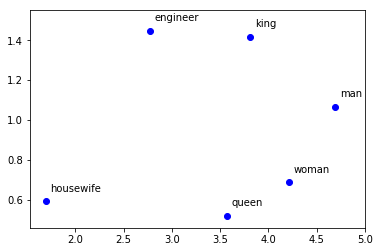

In [189]:
gender_ax = plot_embeddings(['man', 'woman', 'queen', 'king', 'engineer', 'housewife'], embeddings_2d, 'blue') 
#base: man-woman, true: queen - king, false: engineer - housewife
gender_ax.set_xlim(right=5)
gender_ax.set_ylim(top = 1.55)

(0.06473013401858435, 1.3)

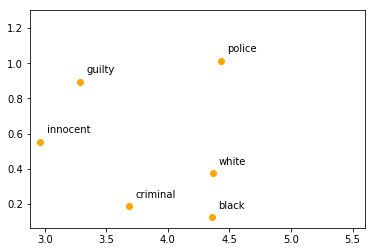

In [192]:
race_ax = plot_embeddings(['criminal', 'police', 'black', 'white', 'guilty', 'innocent'], embeddings_2d, 'orange') 
#base: innocent-guilty, true: police - criminal, false: black - white

race_ax.set_xlim(right= 5.6)
race_ax.set_ylim(top = 1.3)

(-0.3662851480117592, 1.7)

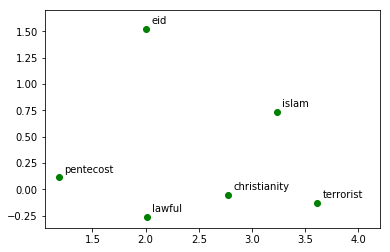

In [321]:
religion_ax = plot_embeddings(['islam', 'christianity', 'terrorist', 'lawful', 'eid', 'pentecost'], embeddings_2d, 'green')
#base: islam-christianity, true: eid - pentecost, false: terrorist - lawful
religion_ax.set_xlim(right= 4.2)
religion_ax.set_ylim(top = 1.7)

## Comparing Words

Hopefully we were able to see some of the relationships between a couple of our data points! Let's now look at some mathematical properties of the embeddings. The first thing we can do is look at cosine similarity, which gives us the cosine of the angle between two vectors. The reason we use it over a spatial measure like Euclidean distance is because we're really trying to look at the relationship _between_ words. 

Although "man" and "engineer" might be extremely far from each other in our vector space, the relationship between the vectors for "engineer" and "woman" might be different. Additionally, the words for "doctor" and "nurse" appear much closer than other words based on gender, possibly pointing to the amount of male nurses and female doctors mentioned in the training corpus.

In [43]:
def comp_words(target, relation):
    target_embedding = embeddings['target']
    return [(relation[0], cosine_similarity([target_embedding], [embeddings[relation[0]]])[0]),
             (relation[1], cosine_similarity([target_embedding], [embeddings[relation[1]]])[0])]
    

In [48]:
comp_words('engineer', ['man', 'woman']) #gender stereotypes in engineering

[('man', array([0.42758992])), ('woman', array([0.33741925]))]

In [50]:
comp_words('engineer', ['asian', 'african-american']) #model minority myth

[('asian', array([0.42330513])), ('african-american', array([0.02642636]))]

In [46]:
comp_words('terrorist', ['christianity', 'islam']) #islam being associated with terrorism

[('christianity', array([0.17068761])), ('islam', array([0.32167268]))]

In [47]:
comp_words('criminal', ['black', 'white']) #races of criminals

[('black', array([0.32004993])), ('white', array([0.33585093]))]

We don't see too much of a difference for the last relation, but see evident gaps in the cosine similarity among the other words.

### 2. Preprocessing for Further Analysis

Now, we'll go beyond analogies and apply cosine similarity and other operations to look at the entire dataset. 

In order to reduce the dimensionality of our search space, we're only going to consider words that describe people. The WordNet database organizes words based on semantics, so we're going to look at the _hyponyms_(words that could be subcategories of a given word) of the word "person." In WordNet, the entry for a word corresponds to a _synset_, which is a set of _senses_, or contexts, a word could be mentioned in.

The senses of "person" are listed [here](http://wordnetweb.princeton.edu/perl/webwn?s=person&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=), we will use the first one.

Although using built-in tools that perform tasks like named-entity recognition would be useful for this task, these are statistical/neural models that often require the word to be in a sentence. We could also look at databases that contain named entities to get rid of proper nouns, but because many common words are also proper nouns(i.e. the Apple corporation, surnames like Smith and Trump), this wouldn't be the most accurate method.  

In [30]:
def get_hyponyms(synset):
    """Get all words that are considered subcategories, or hyponyms of a particular noun.
    Takes in a WordNet Synset object, returns a set of words that are part of that synset"""
    hyponyms = set()
    for hyponym in synset.hyponyms():
        hyponyms |= set(get_hyponyms(hyponym)) #Gets union of all the hyponyms of the word
    hyponyms = hyponyms | set(synset.hyponyms())
    return hyponyms

types_of_people = {synset.name().split('.')[0] for synset in get_hyponyms(wn.synset('person.n.01'))}

We also hard-code a list of gender-specific words, and add additional logic to a function to tell us if a word is specific to the male or female gender using the following lists from Danielle Sucher's [repo](https://github.com/DanielleSucher/Jailbreak-the-Patriarchy).

In [373]:
#From Danielle Sucher's https://github.com/DanielleSucher/Jailbreak-the-Patriarchy
male_words=set(['guy','spokesman','chairman',"men's",'men','him',"he's",'his',
                'boy','boyfriend','boyfriends','boys','brother','brothers','dad','dads','dude','father','fathers',
                'fiance','gentleman','gentlemen','god','grandfather','grandpa','grandson','groom','he','himself',
                'husband','husbands','king','male','man','mr','nephew','nephews','priest','prince','son',
                'sons','uncle','uncles','waiter','widower','widowers'])
female_words=set(['heroine','spokeswoman','chairwoman',"women's",
                  'actress','women',"she's",'her','aunt','aunts','bride',
                  'daughter','daughters','female','fiancee','girl','girlfriend','girlfriends','girls',
                  'goddess','granddaughter','grandma','grandmother','herself','ladies','lady','lady','mom',
                  'moms','mother','mothers','mrs','ms','niece','nieces','priestess','princess','queens','she',
                  'sister','sisters','waitress','widow','widows','wife','wives','woman'])
def gender_neutral(word):
    """Takes in a word and returns True if the word does not belong to """
    return (word not in male_words) and (word not in female_words) and (not word.endswith('man')) and (not word.endswith('woman'))


### 3. Finding the Closest Words

Using our embeddings for people, let's look at the most similar words to a target word, like "man."

In [56]:
def closest_persons(k, word, gender_bias = False):
    #Here, we can use the cosine similarity array returned by k_nearest_vectors!
    """Takes in an integer, a word, and a flag if we're detecting gender bias to only include gender neutral words.
    Returns a list of tuples in the following format 
    (word, cosine similarity to target, numerical rank of word with respect to target).
    Because k_nearest_vectors outputs all types of vectors, the output will not have length k"""
    k_nearest = k_nearest_vectors(k, matrix, [embeddings[word]])
    people_tuples = [(vocab[k_nearest[0][i]], k_nearest[1][i], i) for i in np.arange(len(k_nearest[0])) 
            if vocab[k_nearest[0][i]] in types_of_people and vocab[k_nearest[0][i]] != word]
    if gender_bias:
        people_tuples = [t for t in people_tuples if gender_neutral(t[0])]
    return people_tuples

In [58]:
compare_persons(300, 'man', gender_bias = True)

[('life', 0.7371696782207191, 7),
 ('friend', 0.7170529706205984, 17),
 ('victim', 0.7082503974622372, 22),
 ('hand', 0.6704838539317455, 43),
 ('child', 0.6682647764797975, 47),
 ('hero', 0.6675072516075166, 50),
 ('soldier', 0.6572092481205023, 62),
 ('face', 0.6513383454136314, 73),
 ('shot', 0.6459691581360679, 89),
 ('character', 0.6392505276292051, 101),
 ('black', 0.6352095962184885, 113),
 ('back', 0.6348550425102408, 115),
 ('great', 0.6293664692090448, 131),
 ('head', 0.6289984883078916, 133),
 ('killer', 0.6218355513843233, 150),
 ('suspect', 0.6215987415548052, 152),
 ('lover', 0.6208189942315082, 156),
 ('sort', 0.6158453620191224, 168),
 ('best', 0.6132266626021035, 172),
 ('case', 0.6110351880748324, 181),
 ('doctor', 0.6092161526918836, 188),
 ('second', 0.6075386022692146, 197),
 ('name', 0.5984954299386631, 227),
 ('star', 0.5968591434323185, 232),
 ('self', 0.5865607346224554, 273),
 ('baby', 0.5813004476031609, 292),
 ('cousin', 0.5811990645794511, 293),
 ('witness'

In [636]:
compare_persons(200, 'woman', gender_bias = True)

[('victim', 0.6407717678973269, 14),
 ('child', 0.6294301260530981, 16),
 ('lover', 0.5692697895600373, 28),
 ('nurse', 0.5646969077183875, 30),
 ('friend', 0.564160484551198, 31),
 ('life', 0.5593739976157563, 33),
 ('soldier', 0.5581014336367704, 36),
 ('worker', 0.5545941541036009, 39),
 ('prostitute', 0.5371960748744896, 47),
 ('baby', 0.5344769899519755, 52),
 ('teacher', 0.5338314430177431, 53),
 ('housewife', 0.531849122933435, 54),
 ('doctor', 0.5293920825671159, 57),
 ('married', 0.5071280346270718, 82),
 ('birth', 0.5048731795435029, 87),
 ('patient', 0.48858733901003293, 118),
 ('black', 0.4878013038637666, 119),
 ('attacker', 0.4832373010057014, 140),
 ('witness', 0.47893709378973437, 153),
 ('athlete', 0.47582035817977636, 164),
 ('case', 0.47466957549254385, 169),
 ('lawyer', 0.4741562391662266, 170),
 ('stranger', 0.47383268845460397, 173),
 ('student', 0.4716806493229572, 180),
 ('politician', 0.47160690569794794, 181),
 ('journalist', 0.4713477539783594, 184),
 ('maid'

For "man" and "woman", we see that there are a lot of gender-specific words like "son" and "daughter," but we also see some trends like "prostitute" and "teacher" being much closer to the vector for "woman," when we see words like "soldier" and "hero" being closer to the vector for "man."

In [612]:
compare_persons(60, 'citizen')

[('journalist', 0.5365671755406114, 4),
 ('resident', 0.5335940780111741, 5),
 ('american', 0.524323772697212, 7),
 ('immigrant', 0.5149044179025113, 9),
 ('canadian', 0.5087608372053418, 10),
 ('businessman', 0.4919954582587013, 15),
 ('ordinary', 0.49197911067484723, 16),
 ('politician', 0.49193664604583437, 17),
 ('lawyer', 0.4886279012698642, 18),
 ('advocate', 0.4798776509638012, 21),
 ('soldier', 0.4706849981014689, 23),
 ('diplomat', 0.47035736040449666, 24),
 ('woman', 0.4632373958648325, 29),
 ('fellow', 0.4516985015782866, 35),
 ('worker', 0.4481144856053686, 37),
 ('student', 0.443539956291243, 41),
 ('member', 0.4352997475956328, 46),
 ('man', 0.43399099844859074, 50),
 ('jew', 0.42736058974833313, 58)]

In [597]:
compare_persons(100, 'immigrant')

[('migrant', 0.6586581622064355, 2),
 ('worker', 0.5467345173802629, 7),
 ('haitian', 0.5171931693127529, 10),
 ('citizen', 0.5149044179025113, 11),
 ('refugee', 0.4999778243758676, 19),
 ('mexican', 0.4850413018421284, 21),
 ('african-american', 0.4609086396751774, 35),
 ('child', 0.45092261580120474, 42),
 ('laborer', 0.44883905259640056, 46),
 ('jew', 0.43974927338906955, 53),
 ('native', 0.43409641745666205, 58),
 ('slave', 0.4277706757138491, 67),
 ('peasant', 0.42618831955368186, 69),
 ('mother', 0.41915443702011984, 76),
 ('settler', 0.41906893504267106, 77),
 ('ethnic', 0.4190071505342275, 78),
 ('hmong', 0.41789418111914434, 81),
 ('homeless', 0.41577220439169393, 87),
 ('gypsy', 0.4137312893354037, 89),
 ('cuban', 0.41006546518145714, 94)]

For "citizen" and "immigrant," we see terms that are biased toward professional occupations and poverty, respectively. "Immigrant" yielded more nationalities than "citizen." Inputting specific nationalities only outputted vectors for other nationalities (i.e. "american" is near "canadian")

In [605]:
compare_persons(100, 'islam')

[('muslim', 0.63936552999292, 4),
 ('religious', 0.6055856303162457, 6),
 ('prophet', 0.5690866955013705, 10),
 ('fundamentalist', 0.5615563148585314, 12),
 ('imam', 0.5159405941281745, 24),
 ('extremist', 0.5112426507672221, 26),
 ('sufi', 0.4988681944633398, 33),
 ('radical', 0.4985477790676014, 34),
 ('wahhabi', 0.47694639943682626, 53),
 ('shiite', 0.4716709054408388, 58),
 ('militant', 0.4659725130662824, 60),
 ('islamist', 0.46129436122721695, 64),
 ('cleric', 0.4462623660480373, 72),
 ('christian', 0.43232337579933255, 87),
 ('arab', 0.42549909536029623, 97)]

In [610]:
compare_persons(100, 'christianity')

[('religious', 0.5704454681564426, 23),
 ('christian', 0.5650218802997707, 26),
 ('pagan', 0.5551570324668353, 28),
 ('roman', 0.48583317469927545, 65),
 ('catholic', 0.4855725548429508, 66),
 ('convert', 0.48535247510562557, 67),
 ('protestant', 0.4639060874298178, 84),
 ('byzantine', 0.4615717798917954, 86),
 ('pentecostal', 0.4601624667361376, 90)]

Along with religious words, the vector for "islam" is also close to words like "militant" and "extremist," but this trend does not appear for other religions like Christianity. As a whole, this approach allows us to see some trends, but nothing too specific. In the next notebook, we'll learn about at an alternative way to quantify bias, implement it, and visualize our results!